# Time Series

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Cargamos los datos

In [3]:
url="https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv"

data=pd.read_csv(url)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


Vamos a ver cómo son nuestros datos y gráficamente qué tenemos

In [4]:
data.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


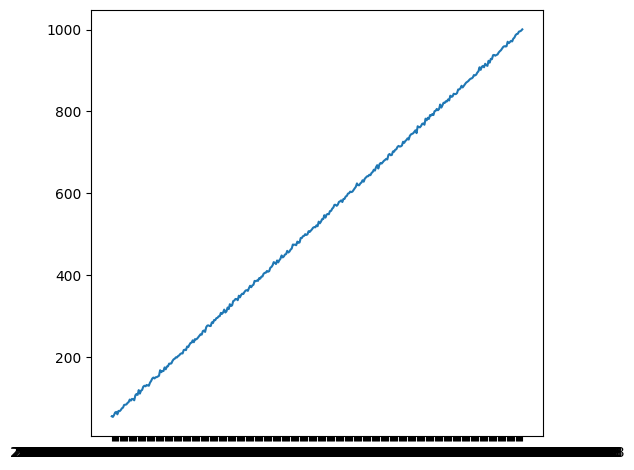

In [5]:
plt.plot(data["date"],data["sales"])

plt.tight_layout()
plt.show()

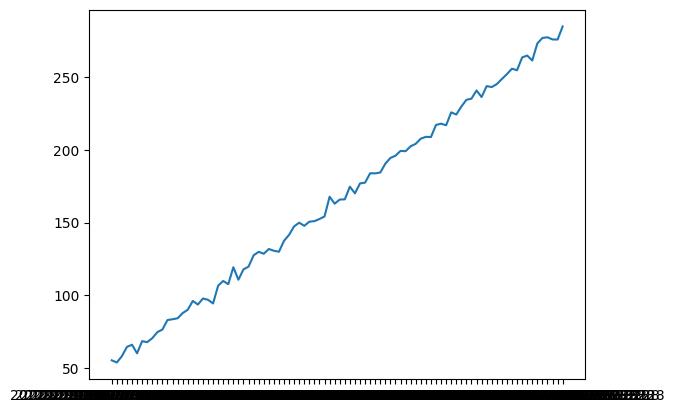

In [6]:
plt.plot(data["date"][0:90],data["sales"][0:90])

Transformamos la variable date

In [7]:
data["fecha"]=pd.to_datetime(data["date"])
data["year"]=data["fecha"].dt.year
data["month"]=data["fecha"].dt.month
data["day"]=data["fecha"].dt.day
data.head()

,date,sales,fecha,year,month,day
0,2022-09-03 17:10:08.079328,55.292157,2022-09-03 17:10:08.079328,2022,9,3
1,2022-09-04 17:10:08.079328,53.803211,2022-09-04 17:10:08.079328,2022,9,4
2,2022-09-05 17:10:08.079328,58.141693,2022-09-05 17:10:08.079328,2022,9,5
3,2022-09-06 17:10:08.079328,64.530899,2022-09-06 17:10:08.079328,2022,9,6
4,2022-09-07 17:10:08.079328,66.013633,2022-09-07 17:10:08.079328,2022,9,7


In [8]:
print("min:", data["fecha"].min(),"\nmax:",data["fecha"].max())

min: 2022-09-03 17:10:08.079328 
max: 2023-09-03 17:10:08.079328


Comprobamos que la hora siempre es la misma

In [9]:
hora=data["fecha"].dt.hour
minuto=data["fecha"].dt.minute
segundo=data["fecha"].dt.second

print(f"hora:{hora.unique()}, minutos: {minuto.unique()}, segundos: {segundo.unique()}")


hora:[17], minutos: [10], segundos: [8]


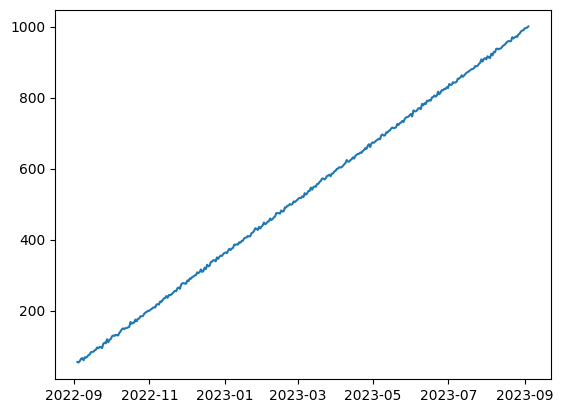

In [10]:
plt.plot(data["fecha"],data["sales"])

Veamos filtro mensual y anual (agrupando meses)

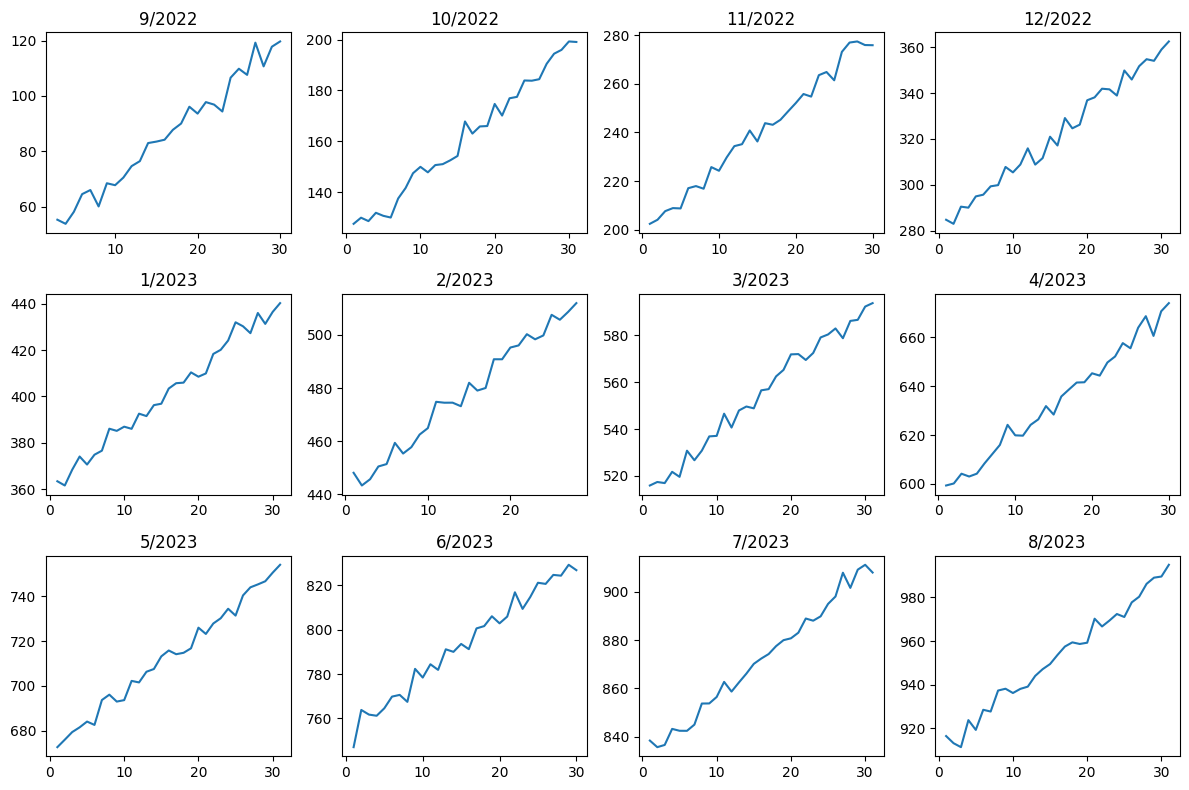

In [11]:
fig, axis= plt.subplots(3,4,figsize=(12,8))

months=[9,10,11,12,1,2,3,4,5,6,7,8]
year=[2022,2022,2022,2022,2023,2023,2023,2023,2023,2023,2023,2023]
j=0
k=0
for i in range(len(months)):
    x=data["day"][(data["month"]==months[i]) & (data["year"]==year[i])]
    y=data["sales"][(data["month"]==months[i]) & (data["year"]==year[i])]
    axis[j,k].plot(x,y)
    axis[j,k].set_title(str(months[i])+"/"+str(year[i]))
    if k==3:
        k=0
        j+=1
    else: k+=1
    plt.tight_layout()

Veamos agrupando mensualmente

In [12]:
data_anual=data.groupby(["year","month"])["sales"].sum()
data_anual.head()

year  month
2022  9         2414.686283
      10        5003.489725
      11        7222.754628
      12        9990.371237
2023  1        12450.943431
Name: sales, dtype: float64

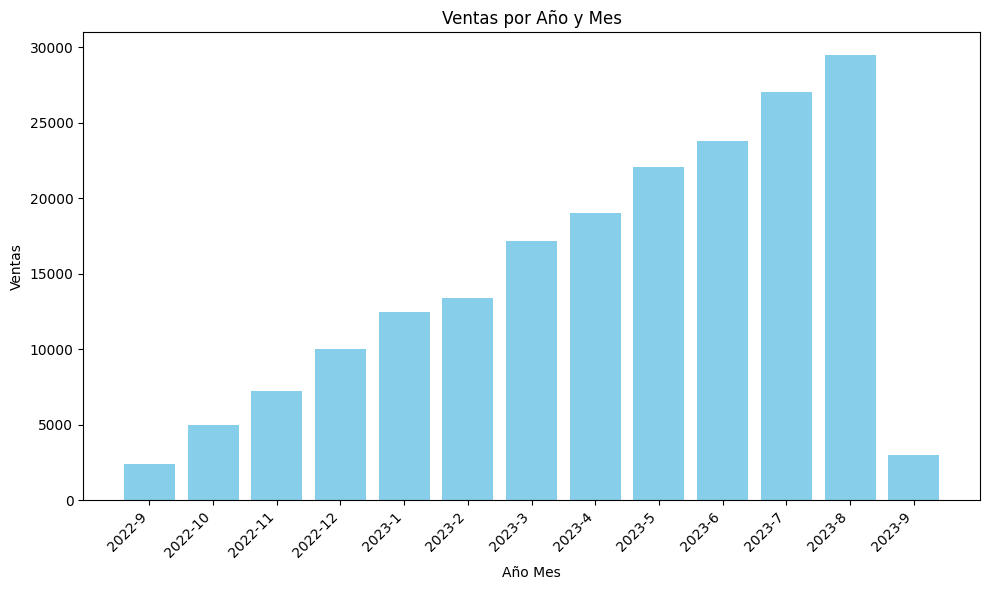

In [13]:
years_months = [f"{key[0]}-{key[1]}" for key in data_anual.index]
values = list(data_anual.values)  

plt.figure(figsize=(10, 6))
plt.bar(years_months, values, color='skyblue')

plt.xlabel('Año Mes')
plt.ylabel('Ventas')
plt.title('Ventas por Año y Mes')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

Vemos que la tendencia es practicamente lineal, creciente y constante. Mensualmente vemos lo mismo, según el número de días del mes, el valor total tiene un crecimiento mayor o menor.

El tensor es diario.

Visualmente, no apreciamos estacionalidad, ni variabilidad, ni puntos de inflexión ni atípicos, y una tendencia lineal creciente.

Vamos a comprobarlo computacionalmente:

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime

fecha= data["date"].str[:10]
data["index"]=fecha

data_ts = data.set_index("index")
ts=data_ts["sales"]
ts
decomposition = seasonal_decompose(ts, period = 30)
decomposition

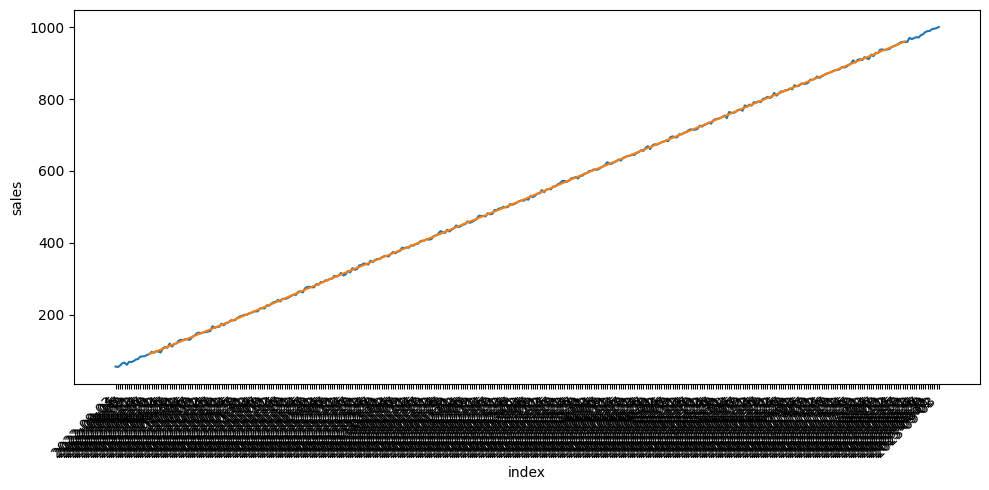

In [15]:
trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = trend)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()


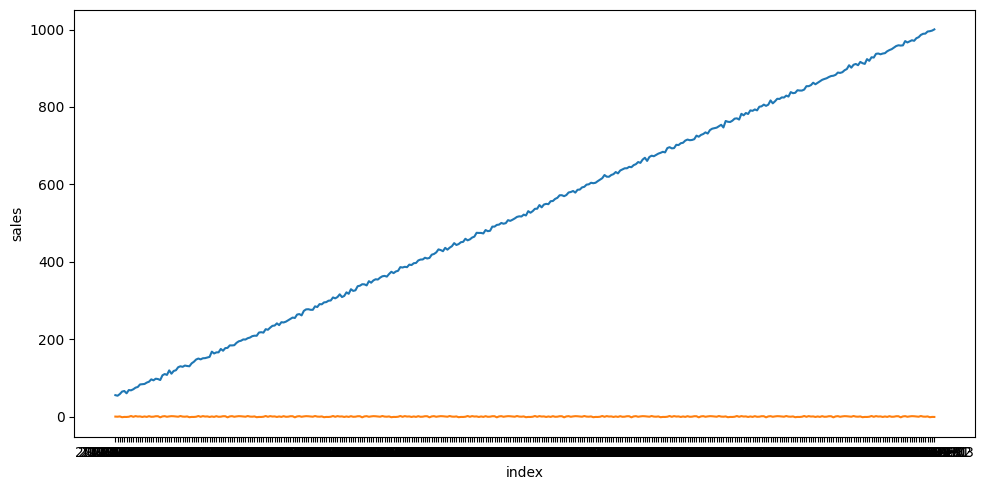

In [16]:
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

In [17]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(ts)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

Vemos que el p-valor es más alto de 0,05 y 0,10, por tanto, se rechaza la hipotesis nula y se confirma que la serie es **no estacionaria**
Y se confirme una clara tendencia creciente

Veamos la variabilidad con el estudio de los residuos

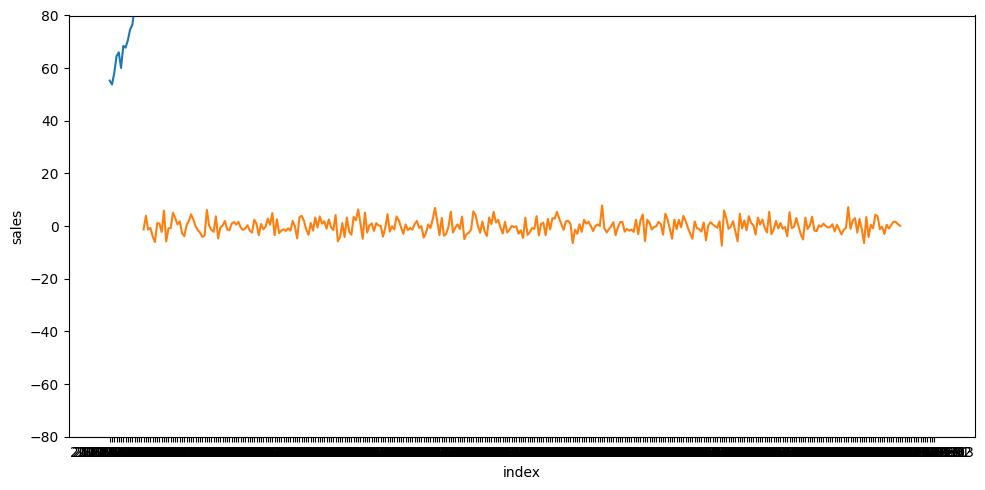

In [18]:
residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = residual)
plt.ylim(-80,80)
plt.tight_layout()

plt.show()

No se aprecia una variabilidad en los datos

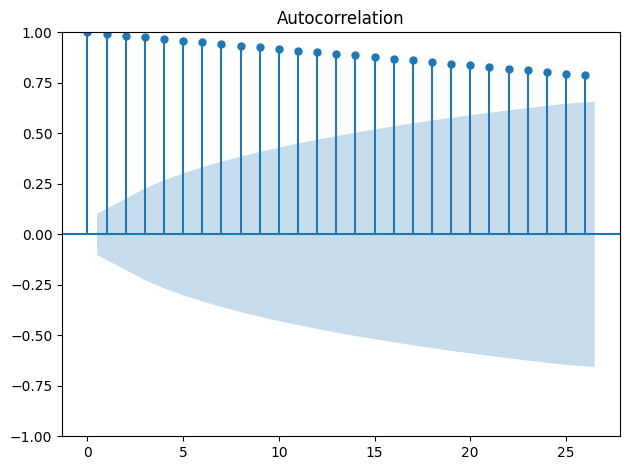

In [19]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ts)

plt.tight_layout()

plt.show()

Se aprecia una alta correlación entre los puntos y sus copias retrasadas

ENTRENAMIENTO DEL MODELO:


Este tipo de series de datos, no necesitan un modelo arima para realizar una previsión ya que la tendencia es muy lineal, se podría directamente prever con una recta de regresión y se minimizarían los errores directamente con ese tipo de previsión.



Sin embargo, para completar el ejercicio, vamos a transformar los datos para hacerlos estacionarios y vamos a entrenar un arima automático:

In [47]:
ts_stationary = ts.diff().dropna()

test_stationarity(ts_stationary)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

<Axes: xlabel='index', ylabel='sales'>

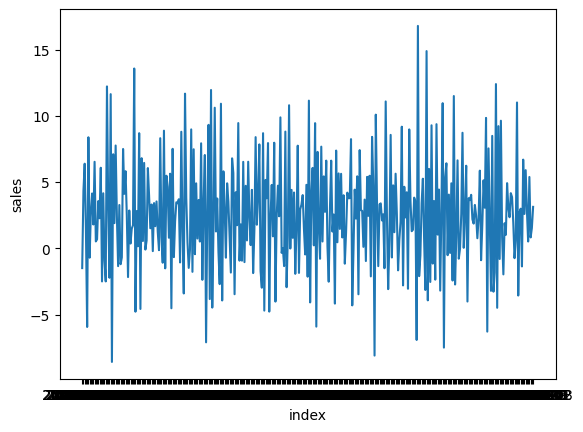

In [48]:
sns.lineplot(data = ts_stationary)

Separamos la serie para obtener una muestra de entrenamiento y una muestra test:

In [49]:
from sklearn.model_selection import train_test_split

X=pd.DataFrame(ts_stationary)

X_train,X_test=train_test_split(X,test_size=0.2,random_state=42)
X_test.info()
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73 entries, 2023-03-16 to 2023-07-26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   73 non-null     float64
dtypes: float64(1)
memory usage: 1.1+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 292 entries, 2023-04-03 to 2022-12-15
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   292 non-null    float64
dtypes: float64(1)
memory usage: 4.6+ KB


Ahora que tenemos la serie estacionaria, ya podemos aplicar un ARIMA automático:

In [50]:
from pmdarima import auto_arima

model = auto_arima(X_train, seasonal = True, trace = True, m = 7)

Performing stepwise search to minimize aic


 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=1686.596, Time=0.97 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=1681.742, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=1681.562, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=1681.247, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=1759.361, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=1680.238, Time=0.04 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=1681.117, Time=0.12 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=1681.672, Time=0.60 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=1681.362, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[7] intercept   : AIC=1681.288, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=1680.675, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[7] intercept   : AIC=1683.287, Time=0.27 sec
 ARIMA(0,0,1)(0,0,0)[7]             : AIC=1736.445, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[7] intercept
Total fit time: 2.587 seconds


In [51]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  292
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -837.119
Date:                Sun, 18 Feb 2024   AIC                           1680.238
Time:                        16:03:08   BIC                           1691.269
Sample:                             0   HQIC                          1684.657
                                - 292                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3997      0.284      8.443      0.000       1.843       2.957
ma.L1          0.1171      0.056      2.089      0.037       0.007       0.227
sigma2        18.0971      1.518     11.923      0.000      15.122      21.072
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.74
Prob(Q):                              0.91   Prob(JB):                         0.25
Heteroskedasticity (H):               0.87   Skew:                             0.24
Prob(H) (two-sided):                  0.49   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Hacemos las previsiones y comparamos con el test

In [52]:
forecast = model.predict(73)
forecast

/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


292    3.202302
293    2.399716
294    2.399716
295    2.399716
296    2.399716
         ...   
360    2.399716
361    2.399716
362    2.399716
363    2.399716
364    2.399716
Length: 73, dtype: float64

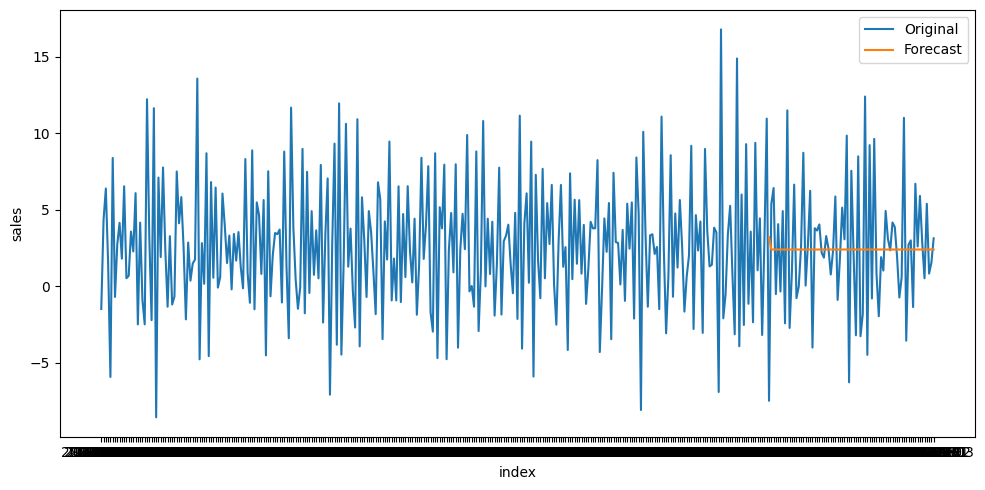

In [53]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_stationary,label="Original")

sns.lineplot(data = forecast,label="Forecast")

plt.legend()
plt.tight_layout()

plt.show()

Como comentabamos, para la prevision de este tipo de series, la media es el valor que minimiza los errores. Transformado a valores originales seria la linea de tendencia la prevision mas acertada.